In [62]:
# ============================== NEW MULTI-FOLDER LOADER ==============================
import os, re, time
import datetime as dt
from pathlib import Path
import numpy as np
import pandas as pd


PLOTS_DIR = Path("plots")
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

# ----------------------------
# 1) Time helpers & parameters
# ----------------------------
def ts(dmys_hm: str) -> int:
    """Parse 'dd.mm.yyyy HH:MM' as local time to epoch seconds (int)."""
    return int(time.mktime(dt.datetime.strptime(dmys_hm, "%d.%m.%Y %H:%M").timetuple()))

timeBeginningDataframes = ts("01.04.2024 00:00")
timeEndingDataframes    = ts("01.03.2025 00:00")

timeOffsetPlot        = ts("01.05.2024 00:00")
timeOffsetTensiomark  = ts("01.04.2024 00:00")
timeOffsetClimavi     = ts("23.07.2024 00:00")
timeOffsetPlantobelly = ts("01.06.2024 00:00")
timeOffsetWatermark   = ts("01.04.2024 00:00")
timeOffsetSMT100      = ts("01.04.2024 00:00")

offset_by_sensor = {
    "Tensiomark":  timeOffsetTensiomark,
    "Climavi":     timeOffsetClimavi,
    "Plantobelly": timeOffsetPlantobelly,
    "Watermark":   timeOffsetWatermark,
    "SMT100":      timeOffsetSMT100,
}

# --------------------------------
# 2) Repository layout assumptions
# --------------------------------
# This notebook's directory contains subfolders named like below:
SENSOR_DIRS = {
    "climavi":     "Climavi",
    "tensiomark":  "Tensiomark",
    "smt100":      "SMT100",
    "watermark":   "Watermark",
    "plantobelly": "Plantobelly",
}
BASE = Path(".").resolve()

# ----------------------------
# 3) Filename → tree extractor
# ----------------------------
# Works for "Climavi 3.csv", "Plantobelly_2.csv", "Watermark-5.csv" etc.
TREE_RE = re.compile(r"(\D*)(\d+)$")  # capture trailing number
def parse_tree_from_stem(stem: str) -> int | None:
    # strip typical separators and file-type words
    cleaned = re.sub(r"[_\-\s]+", " ", stem).strip()
    m = TREE_RE.search(cleaned)
    if not m:
        return None
    try:
        return int(m.group(2))
    except Exception:
        return None

# ----------------------------
# 4) Depth normalization rules
# ----------------------------
# Keep your legacy labels. For Climavi, map negative depths to Ballen/30/60.
def normalize_depth(sensor: str, col: str) -> str | None:
    c = str(col).strip()
    if c.lower() in {"timestamp", "timestamp_unix", "time", "epoch"}:
        return None  # not a depth column
    if sensor == "Climavi":
        mapping = {"-10": "Ballen", "-30": "30", "-45": "60",
                   "Ballen": "Ballen", "30": "30", "60": "60"}
        return mapping.get(c, c)
    # others already use Ballen/30/60(/90)
    return c

# ------------------------------------------
# 5) Read all CSVs and build Data_* frames
# ------------------------------------------
frames: dict[str, pd.DataFrame] = {}

def add_frame(sensor: str, tree: int, depth: str, df_depth: pd.DataFrame):
    """Store sorted  ['timestamp','value']  under key Data_{sensor}_{tree}_{depth}."""
    key = f"Data_{sensor}_{tree}_{depth}"
    # sort, type-cast, and filter by offsets and global window
    out = df_depth.copy()
    out = out.dropna(subset=["timestamp"]).copy()
    out["timestamp"] = pd.to_numeric(out["timestamp"], errors="coerce").astype("Int64")
    out = out.dropna(subset=["timestamp"]).copy()
    out["timestamp"] = out["timestamp"].astype("int64")
    out["value"]     = pd.to_numeric(out["value"], errors="coerce")

    # sensor-specific offsets + global window
    off = offset_by_sensor.get(sensor, -np.inf)
    out = out[(out["timestamp"] >= timeBeginningDataframes) &
              (out["timestamp"] <= timeEndingDataframes) &
              (out["timestamp"] >  off)]

    out = out.sort_values("timestamp").reset_index(drop=True)
    frames[key] = out

def load_folder(local_name: str, sensor_label: str):
    """
    local_name: folder on disk (e.g., 'plantobelly')
    sensor_label: canonical name used in variable keys (e.g., 'Plantobelly')
    """
    folder = BASE / local_name
    if not folder.exists():
        return

    for csv_path in sorted(folder.rglob("*.csv")):
        stem = csv_path.stem  # e.g., "Plantobelly 2"
        tree = parse_tree_from_stem(stem)
        if tree is None:
            # skip files where tree couldn't be parsed
            continue

        try:
            df = pd.read_csv(csv_path)
        except Exception:
            continue

        # Find timestamp column
        ts_col = None
        for cand in ["timestamp_unix", "timestamp", "time", "epoch"]:
            if cand in df.columns:
                ts_col = cand
                break
        if ts_col is None:
            # cannot use without timestamp
            continue

        # For every depth column present, create a 2-col dataframe
        for col in df.columns:
            depth_norm = normalize_depth(sensor_label, col)
            if depth_norm is None:
                continue  # skip timestamp-like columns
            if depth_norm not in {"Ballen", "30", "60", "90"}:
                # Ignore unexpected columns silently
                continue

            two_col = pd.DataFrame({
                "timestamp": df[ts_col],
                "value":     df[col]
            })
            add_frame(sensor_label, tree, depth_norm, two_col)

# Run loader for all sensor groups
for local, label in SENSOR_DIRS.items():
    load_folder(local, label)

# -----------------------------------------------------
# 6) Backward-compatible globals (Data_Sensor_T_D = df)
# -----------------------------------------------------
# Expose variables like Data_Tensiomark_3_Ballen for your downstream code.
g = globals()
for key, df in frames.items():
    g[key] = df.copy()

# Optional helper (same as before), in case you want to access safely:
def get_frame(sensor: str, tree: int, depth: str) -> pd.DataFrame:
    k = f"Data_{sensor}_{tree}_{depth}"
    if k in frames:
        return frames[k].copy()
    return pd.DataFrame({"timestamp": pd.Series(dtype="int64"),
                         "value":     pd.Series(dtype="float64")})

# ----------------------------
# 7) Quick sanity-check (optional)
# ----------------------------
# print some keys that were found
# print(sorted(list(frames.keys()))[:12])
# ===============================================================================


In [63]:
# ----- hourly grid (INT, sorted) -----
timestamps = np.arange(timeBeginningDataframes, timeEndingDataframes, 3600, dtype="int64")
tol = 18000  # seconds = 5h

# ----- what depths exist per sensor type -----
sensor_depths = {
    "Tensiomark":  ["Ballen", "30", "60"],
    "Climavi":     ["Ballen", "30", "60"],
    "Plantobelly": ["Ballen", "30", "60"],
    "Watermark":   ["Ballen", "30", "60", "90"],
    "SMT100":      ["Ballen", "30", "60"],
}

# depth order to generate (90 only exists for Watermark; others will simply remain NaN if no sources)
depth_order = ["Ballen", "30", "60", "90"]
trees = [1, 2, 3, 4, 5]

# ----- helpers -----
def ensure_int_ts_sorted(df: pd.DataFrame) -> pd.DataFrame:
    """Return df with int64 'timestamp', sorted; or empty df with correct dtypes."""
    if df is None or df.empty:
        return pd.DataFrame({"timestamp": pd.Series(dtype="int64"),
                             "value": pd.Series(dtype="float64")})
    out = df.copy()
    out["timestamp"] = out["timestamp"].astype("int64")
    return out.sort_values("timestamp")

def fetch_source_df(varname: str) -> pd.DataFrame:
    """
    Try to get a per-sensor DataFrame by name from:
      1) a 'frames' dict (from the earlier tidy rewrite), or
      2) globals() (if you still have variables like Data_Tensiomark_3_30)
    """
    if "frames" in globals() and isinstance(globals()["frames"], dict) and varname in globals()["frames"]:
        return globals()["frames"][varname]
    if varname in globals():
        return globals()[varname]
    return pd.DataFrame({"timestamp": pd.Series(dtype="int64"),
                         "value": pd.Series(dtype="float64")})

def merge_sensor(base: pd.DataFrame, source: pd.DataFrame, newcol: str) -> pd.DataFrame:
    """Asof-merge one sensor's 'value' onto base by 'timestamp', with forward fill within tolerance."""
    source = ensure_int_ts_sorted(source)
    if source.empty:
        base[newcol] = np.nan
        return base
    out = pd.merge_asof(
        base, source[["timestamp", "value"]],
        on="timestamp",
        direction="forward",
        tolerance=tol
    )
    return out.rename(columns={"value": newcol})

# ----- build ALL Data_Baum_{tree}_{depth} -----
baum_frames = {}  # optional: keep a dict of results too
for tree in trees:
    for depth in depth_order:
        base = pd.DataFrame({"timestamp": timestamps})  # already sorted int64

        # merge all sensors that have this depth
        for sensor, allowed_depths in sensor_depths.items():
            if depth in allowed_depths:
                varname = f"Data_{sensor}_{tree}_{depth}"
                src = fetch_source_df(varname)
                base = merge_sensor(base, src, varname)

        # store to variable name AND a dict (both)
        out_name = f"Data_Baum_{tree}_{depth}"
        globals()[out_name] = base
        baum_frames[out_name] = base

# Example access:
# Data_Baum_3_Ballen, Data_Baum_3_30, Data_Baum_3_60, Data_Baum_3_90
# or baum_frames["Data_Baum_3_Ballen"]


c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-package

[Data_Climavi_1_Ballen vs Data_SMT100_1_Ballen] RMSE: 0.029, std(y): 0.032, NRMSE: 0.909
[bar input] RMSE: 0.029, std: 0.034, NRMSE: 0.909 for Data_Climavi_1_Ballen vs Data_SMT100_1_Ballen
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Climavi_1_Ballen vs Data_Plantobelly_1_Ballen
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_SMT100_1_Ballen vs Data_Plantobelly_1_Ballen
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Watermark_1_Ballen vs Data_Tensiomark_1_Ballen
[bar plot] RMSE: 0.031, std: 0.034, NRMSE: 0.909, m: 0.293, r: 0.417, k: 0.299, rho: 0.389 (Data_SMT100_1_Ballen vs Data_Climavi_1_Ballen)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: nan, r: nan, k: nan, rho: nan (Data_Plantobelly_1_Ballen vs Data_Climavi_1_Ballen)
[bar plot] RMSE: 0.470, std: 0.319, NRMSE: 1.476, m: 0.000, r: -0.612, k: -0.457, rho: -0.620 (Data_Watermark_1_Ballen vs Data_Climavi_1_Ballen)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: 0.000, r: nan, k: nan, rho: nan (Data_Tensiomark_1_Ba

c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-package

[Data_Climavi_1_30 vs Data_SMT100_1_30] RMSE: 0.022, std(y): 0.026, NRMSE: 0.856
[bar input] RMSE: 0.022, std: 0.031, NRMSE: 0.856 for Data_Climavi_1_30 vs Data_SMT100_1_30
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Climavi_1_30 vs Data_Plantobelly_1_30
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_SMT100_1_30 vs Data_Plantobelly_1_30
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Watermark_1_30 vs Data_Tensiomark_1_30
[bar plot] RMSE: 0.027, std: 0.031, NRMSE: 0.856, m: 0.293, r: 0.517, k: 0.443, rho: 0.595 (Data_SMT100_1_30 vs Data_Climavi_1_30)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: nan, r: nan, k: nan, rho: nan (Data_Plantobelly_1_30 vs Data_Climavi_1_30)
[bar plot] RMSE: 0.431, std: 0.392, NRMSE: 1.099, m: 0.000, r: -0.696, k: -0.591, rho: -0.750 (Data_Watermark_1_30 vs Data_Climavi_1_30)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: 0.000, r: nan, k: nan, rho: nan (Data_Tensiomark_1_30 vs Data_Climavi_1_30)
[bar plot] RMSE: nan, std: nan, NRMSE: na

c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-package

[Data_Climavi_1_60 vs Data_SMT100_1_60] RMSE: 0.028, std(y): 0.028, NRMSE: 0.988
[bar input] RMSE: 0.028, std: 0.036, NRMSE: 0.988 for Data_Climavi_1_60 vs Data_SMT100_1_60
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Climavi_1_60 vs Data_Plantobelly_1_60
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_SMT100_1_60 vs Data_Plantobelly_1_60
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Watermark_1_60 vs Data_Tensiomark_1_60
[bar plot] RMSE: 0.035, std: 0.036, NRMSE: 0.988, m: 0.127, r: 0.153, k: 0.108, rho: 0.173 (Data_SMT100_1_60 vs Data_Climavi_1_60)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: nan, r: nan, k: nan, rho: nan (Data_Plantobelly_1_60 vs Data_Climavi_1_60)
[bar plot] RMSE: 0.371, std: 0.399, NRMSE: 0.932, m: 0.000, r: -0.325, k: -0.305, rho: -0.456 (Data_Watermark_1_60 vs Data_Climavi_1_60)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: 0.000, r: nan, k: nan, rho: nan (Data_Tensiomark_1_60 vs Data_Climavi_1_60)
[bar plot] RMSE: nan, std: nan, NRMSE: na

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)


[Data_Climavi_2_30 vs Data_SMT100_2_30] RMSE: 0.018, std(y): 0.018, NRMSE: 0.998
[bar input] RMSE: 0.018, std: 0.025, NRMSE: 0.998 for Data_Climavi_2_30 vs Data_SMT100_2_30
[Data_Climavi_2_30 vs Data_Plantobelly_2_30] RMSE: 0.022, std(y): 0.024, NRMSE: 0.917
[bar input] RMSE: 0.022, std: 0.027, NRMSE: 0.917 for Data_Climavi_2_30 vs Data_Plantobelly_2_30
[Data_SMT100_2_30 vs Data_Plantobelly_2_30] RMSE: 0.023, std(y): 0.024, NRMSE: 0.990
[bar input] RMSE: 0.023, std: 0.027, NRMSE: 0.990 for Data_SMT100_2_30 vs Data_Plantobelly_2_30
[Data_Watermark_2_30 vs Data_Tensiomark_2_30] RMSE: 0.255, std(y): 0.256, NRMSE: 0.996
[bar input] RMSE: 0.255, std: 0.258, NRMSE: 0.996 for Data_Watermark_2_30 vs Data_Tensiomark_2_30
[bar plot] RMSE: 0.025, std: 0.025, NRMSE: 0.998, m: -0.036, r: -0.065, k: -0.045, rho: -0.143 (Data_SMT100_2_30 vs Data_Climavi_2_30)
[bar plot] RMSE: 0.024, std: 0.027, NRMSE: 0.917, m: -0.312, r: -0.398, k: -0.292, rho: -0.424 (Data_Plantobelly_2_30 vs Data_Climavi_2_30)
[ba

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)


[Data_Climavi_2_60 vs Data_SMT100_2_60] RMSE: 0.020, std(y): 0.022, NRMSE: 0.878
[bar input] RMSE: 0.020, std: 0.026, NRMSE: 0.878 for Data_Climavi_2_60 vs Data_SMT100_2_60
[Data_Climavi_2_60 vs Data_Plantobelly_2_60] RMSE: 0.033, std(y): 0.035, NRMSE: 0.950
[bar input] RMSE: 0.033, std: 0.035, NRMSE: 0.950 for Data_Climavi_2_60 vs Data_Plantobelly_2_60
[Data_SMT100_2_60 vs Data_Plantobelly_2_60] RMSE: 0.032, std(y): 0.033, NRMSE: 0.978
[bar input] RMSE: 0.032, std: 0.035, NRMSE: 0.978 for Data_SMT100_2_60 vs Data_Plantobelly_2_60
[Data_Watermark_2_60 vs Data_Tensiomark_2_60] RMSE: 0.231, std(y): 0.231, NRMSE: 0.999
[bar input] RMSE: 0.231, std: 0.233, NRMSE: 0.999 for Data_Watermark_2_60 vs Data_Tensiomark_2_60
[bar plot] RMSE: 0.023, std: 0.026, NRMSE: 0.878, m: -0.333, r: -0.478, k: -0.386, rho: -0.504 (Data_SMT100_2_60 vs Data_Climavi_2_60)
[bar plot] RMSE: 0.034, std: 0.035, NRMSE: 0.950, m: -0.348, r: -0.313, k: -0.192, rho: -0.319 (Data_Plantobelly_2_60 vs Data_Climavi_2_60)
[ba

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)


[Data_Climavi_3_Ballen vs Data_SMT100_3_Ballen] RMSE: 0.039, std(y): 0.040, NRMSE: 0.989
[bar input] RMSE: 0.039, std: 0.045, NRMSE: 0.989 for Data_Climavi_3_Ballen vs Data_SMT100_3_Ballen
[Data_Climavi_3_Ballen vs Data_Plantobelly_3_Ballen] RMSE: 0.027, std(y): 0.028, NRMSE: 0.948
[bar input] RMSE: 0.027, std: 0.029, NRMSE: 0.948 for Data_Climavi_3_Ballen vs Data_Plantobelly_3_Ballen
[Data_SMT100_3_Ballen vs Data_Plantobelly_3_Ballen] RMSE: 0.021, std(y): 0.024, NRMSE: 0.847
[bar input] RMSE: 0.021, std: 0.029, NRMSE: 0.847 for Data_SMT100_3_Ballen vs Data_Plantobelly_3_Ballen
[Data_Watermark_3_Ballen vs Data_Tensiomark_3_Ballen] RMSE: 0.222, std(y): 0.468, NRMSE: 0.474
[bar input] RMSE: 0.222, std: 0.496, NRMSE: 0.474 for Data_Watermark_3_Ballen vs Data_Tensiomark_3_Ballen
[bar plot] RMSE: 0.045, std: 0.045, NRMSE: 0.989, m: 0.259, r: 0.150, k: -0.071, rho: -0.101 (Data_SMT100_3_Ballen vs Data_Climavi_3_Ballen)
[bar plot] RMSE: 0.027, std: 0.029, NRMSE: 0.948, m: 0.281, r: 0.318, k: 

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)


[Data_Climavi_3_30 vs Data_SMT100_3_30] RMSE: 0.047, std(y): 0.049, NRMSE: 0.964
[bar input] RMSE: 0.047, std: 0.054, NRMSE: 0.964 for Data_Climavi_3_30 vs Data_SMT100_3_30
[Data_Climavi_3_30 vs Data_Plantobelly_3_30] RMSE: 0.045, std(y): 0.049, NRMSE: 0.908
[bar input] RMSE: 0.045, std: 0.051, NRMSE: 0.908 for Data_Climavi_3_30 vs Data_Plantobelly_3_30
[Data_SMT100_3_30 vs Data_Plantobelly_3_30] RMSE: 0.037, std(y): 0.050, NRMSE: 0.736
[bar input] RMSE: 0.037, std: 0.051, NRMSE: 0.736 for Data_SMT100_3_30 vs Data_Plantobelly_3_30
[Data_Watermark_3_30 vs Data_Tensiomark_3_30] RMSE: 0.345, std(y): 0.437, NRMSE: 0.790
[bar input] RMSE: 0.345, std: 0.482, NRMSE: 0.790 for Data_Watermark_3_30 vs Data_Tensiomark_3_30
[bar plot] RMSE: 0.052, std: 0.054, NRMSE: 0.964, m: 0.636, r: 0.266, k: -0.100, rho: -0.117 (Data_SMT100_3_30 vs Data_Climavi_3_30)
[bar plot] RMSE: 0.046, std: 0.051, NRMSE: 0.908, m: 0.648, r: 0.420, k: 0.165, rho: 0.250 (Data_Plantobelly_3_30 vs Data_Climavi_3_30)
[bar plot

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)


[Data_Climavi_3_60 vs Data_SMT100_3_60] RMSE: 0.019, std(y): 0.019, NRMSE: 0.977
[bar input] RMSE: 0.019, std: 0.019, NRMSE: 0.977 for Data_Climavi_3_60 vs Data_SMT100_3_60
[Data_Climavi_3_60 vs Data_Plantobelly_3_60] RMSE: 0.023, std(y): 0.026, NRMSE: 0.901
[bar input] RMSE: 0.023, std: 0.026, NRMSE: 0.901 for Data_Climavi_3_60 vs Data_Plantobelly_3_60
[Data_SMT100_3_60 vs Data_Plantobelly_3_60] RMSE: 0.023, std(y): 0.023, NRMSE: 0.997
[bar input] RMSE: 0.023, std: 0.026, NRMSE: 0.997 for Data_SMT100_3_60 vs Data_Plantobelly_3_60
[Data_Watermark_3_60 vs Data_Tensiomark_3_60] RMSE: 0.162, std(y): 0.187, NRMSE: 0.865
[bar input] RMSE: 0.162, std: 0.192, NRMSE: 0.865 for Data_Watermark_3_60 vs Data_Tensiomark_3_60
[bar plot] RMSE: 0.019, std: 0.019, NRMSE: 0.977, m: -0.381, r: -0.211, k: -0.235, rho: -0.373 (Data_SMT100_3_60 vs Data_Climavi_3_60)
[bar plot] RMSE: 0.024, std: 0.026, NRMSE: 0.901, m: -0.998, r: -0.435, k: -0.261, rho: -0.373 (Data_Plantobelly_3_60 vs Data_Climavi_3_60)
[ba

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc,

[Data_Climavi_4_Ballen vs Data_SMT100_4_Ballen] RMSE: 0.040, std(y): 0.041, NRMSE: 0.961
[bar input] RMSE: 0.040, std: 0.044, NRMSE: 0.961 for Data_Climavi_4_Ballen vs Data_SMT100_4_Ballen
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Climavi_4_Ballen vs Data_Plantobelly_4_Ballen
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_SMT100_4_Ballen vs Data_Plantobelly_4_Ballen
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Watermark_4_Ballen vs Data_Tensiomark_4_Ballen
[bar plot] RMSE: 0.042, std: 0.044, NRMSE: 0.961, m: 1.317, r: 0.276, k: 0.044, rho: 0.088 (Data_SMT100_4_Ballen vs Data_Climavi_4_Ballen)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: nan, r: nan, k: nan, rho: nan (Data_Plantobelly_4_Ballen vs Data_Climavi_4_Ballen)
[bar plot] RMSE: 0.778, std: 0.347, NRMSE: 2.245, m: 0.000, r: -0.358, k: -0.167, rho: -0.243 (Data_Watermark_4_Ballen vs Data_Climavi_4_Ballen)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: 0.000, r: nan, k: nan, rho: nan (Data_Tensiomark_4_Ba

c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-package

[Data_Climavi_4_30 vs Data_SMT100_4_30] RMSE: 0.030, std(y): 0.030, NRMSE: 0.987
[bar input] RMSE: 0.030, std: 0.030, NRMSE: 0.987 for Data_Climavi_4_30 vs Data_SMT100_4_30
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Climavi_4_30 vs Data_Plantobelly_4_30
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_SMT100_4_30 vs Data_Plantobelly_4_30
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Watermark_4_30 vs Data_Tensiomark_4_30
[bar plot] RMSE: 0.030, std: 0.030, NRMSE: 0.987, m: 0.510, r: 0.162, k: -0.056, rho: -0.031 (Data_SMT100_4_30 vs Data_Climavi_4_30)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: nan, r: nan, k: nan, rho: nan (Data_Plantobelly_4_30 vs Data_Climavi_4_30)
[bar plot] RMSE: 0.528, std: 0.393, NRMSE: 1.345, m: 0.000, r: -0.528, k: -0.360, rho: -0.498 (Data_Watermark_4_30 vs Data_Climavi_4_30)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: 0.000, r: nan, k: nan, rho: nan (Data_Tensiomark_4_30 vs Data_Climavi_4_30)
[bar plot] RMSE: nan, std: nan, NRMSE: 

c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-package

[Data_Climavi_4_60 vs Data_SMT100_4_60] RMSE: 0.012, std(y): 0.012, NRMSE: 0.997
[bar input] RMSE: 0.012, std: 0.021, NRMSE: 0.997 for Data_Climavi_4_60 vs Data_SMT100_4_60
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Climavi_4_60 vs Data_Plantobelly_4_60
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_SMT100_4_60 vs Data_Plantobelly_4_60
[bar input] RMSE: nan, std: nan, NRMSE: nan for Data_Watermark_4_60 vs Data_Tensiomark_4_60
[bar plot] RMSE: 0.020, std: 0.021, NRMSE: 0.997, m: -0.120, r: -0.075, k: -0.139, rho: -0.219 (Data_SMT100_4_60 vs Data_Climavi_4_60)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: nan, r: nan, k: nan, rho: nan (Data_Plantobelly_4_60 vs Data_Climavi_4_60)
[bar plot] RMSE: 0.641, std: 0.350, NRMSE: 1.830, m: 0.000, r: -0.439, k: -0.265, rho: -0.416 (Data_Watermark_4_60 vs Data_Climavi_4_60)
[bar plot] RMSE: nan, std: nan, NRMSE: nan, m: 0.000, r: nan, k: nan, rho: nan (Data_Tensiomark_4_60 vs Data_Climavi_4_60)
[bar plot] RMSE: nan, std: nan, NRMSE

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc,

[Data_Climavi_5_30 vs Data_SMT100_5_30] RMSE: 0.016, std(y): 0.021, NRMSE: 0.778
[bar input] RMSE: 0.016, std: 0.029, NRMSE: 0.778 for Data_Climavi_5_30 vs Data_SMT100_5_30
[Data_Climavi_5_30 vs Data_Plantobelly_5_30] RMSE: 0.031, std(y): 0.032, NRMSE: 0.949
[bar input] RMSE: 0.031, std: 0.042, NRMSE: 0.949 for Data_Climavi_5_30 vs Data_Plantobelly_5_30
[Data_SMT100_5_30 vs Data_Plantobelly_5_30] RMSE: 0.039, std(y): 0.041, NRMSE: 0.952
[bar input] RMSE: 0.039, std: 0.042, NRMSE: 0.952 for Data_SMT100_5_30 vs Data_Plantobelly_5_30
[Data_Watermark_5_30 vs Data_Tensiomark_5_30] RMSE: 0.446, std(y): 0.501, NRMSE: 0.891
[bar input] RMSE: 0.446, std: 0.502, NRMSE: 0.891 for Data_Watermark_5_30 vs Data_Tensiomark_5_30
[bar plot] RMSE: 0.022, std: 0.029, NRMSE: 0.778, m: 0.914, r: 0.628, k: 0.288, rho: 0.407 (Data_SMT100_5_30 vs Data_Climavi_5_30)
[bar plot] RMSE: 0.040, std: 0.042, NRMSE: 0.949, m: 0.547, r: 0.315, k: 0.122, rho: 0.164 (Data_Plantobelly_5_30 vs Data_Climavi_5_30)
[bar plot] 

c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\459012883.py:23: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  return s.fillna(method='ffill', limit=limit)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\tmaie\anaconda3\Lib\site-package

[Data_Climavi_5_60 vs Data_SMT100_5_60] RMSE: 0.017, std(y): 0.019, NRMSE: 0.928
[bar input] RMSE: 0.017, std: 0.032, NRMSE: 0.928 for Data_Climavi_5_60 vs Data_SMT100_5_60
[Data_Climavi_5_60 vs Data_Plantobelly_5_60] RMSE: 0.021, std(y): 0.022, NRMSE: 0.977
[bar input] RMSE: 0.021, std: 0.027, NRMSE: 0.977 for Data_Climavi_5_60 vs Data_Plantobelly_5_60
[Data_SMT100_5_60 vs Data_Plantobelly_5_60] RMSE: 0.025, std(y): 0.025, NRMSE: 0.975
[bar input] RMSE: 0.025, std: 0.027, NRMSE: 0.975 for Data_SMT100_5_60 vs Data_Plantobelly_5_60
[Data_Watermark_5_60 vs Data_Tensiomark_5_60] RMSE: 0.333, std(y): 0.396, NRMSE: 0.841
[bar input] RMSE: 0.333, std: 0.393, NRMSE: 0.841 for Data_Watermark_5_60 vs Data_Tensiomark_5_60
[bar plot] RMSE: 0.030, std: 0.032, NRMSE: 0.928, m: -0.614, r: -0.373, k: -0.257, rho: -0.459 (Data_SMT100_5_60 vs Data_Climavi_5_60)
[bar plot] RMSE: 0.026, std: 0.027, NRMSE: 0.977, m: 0.407, r: 0.216, k: 0.128, rho: 0.177 (Data_Plantobelly_5_60 vs Data_Climavi_5_60)
[bar pl

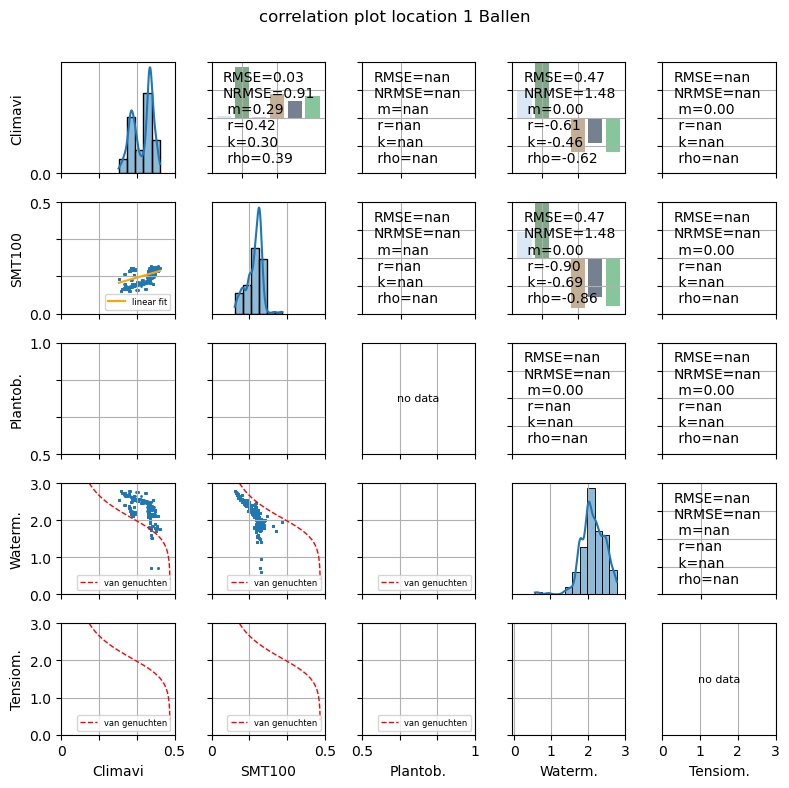

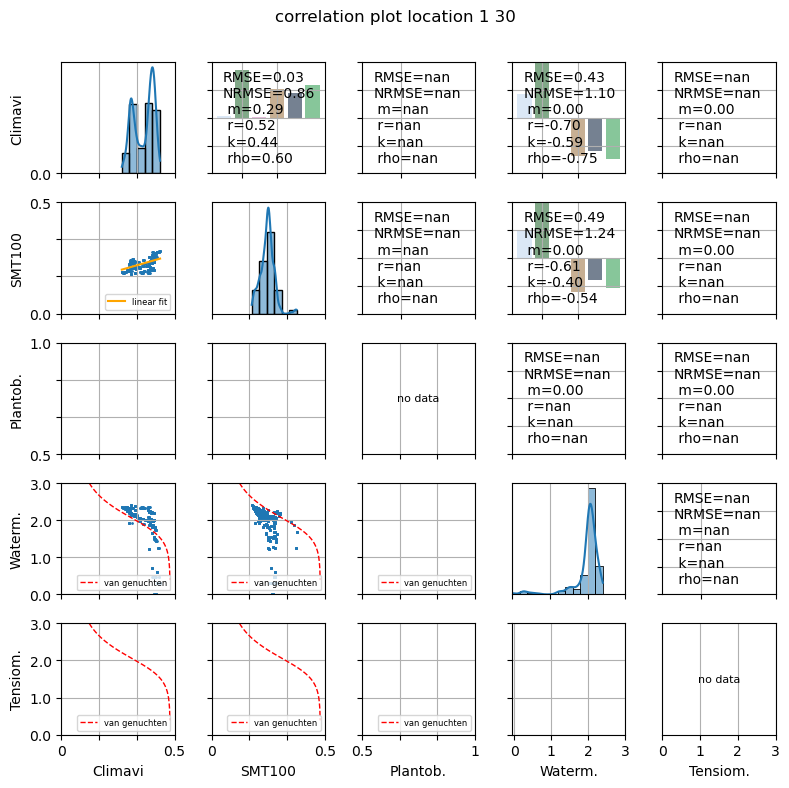

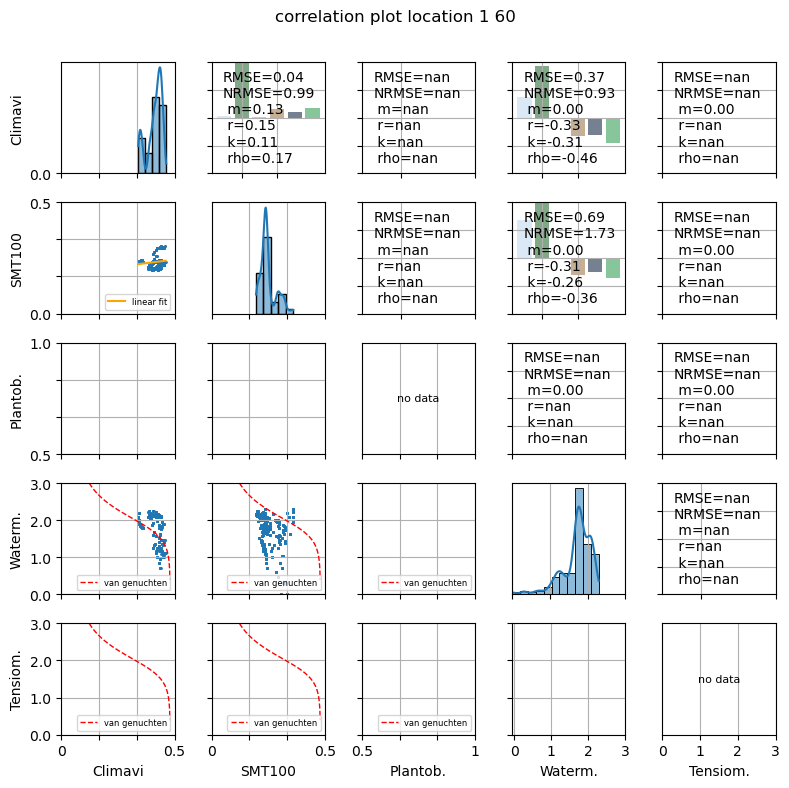

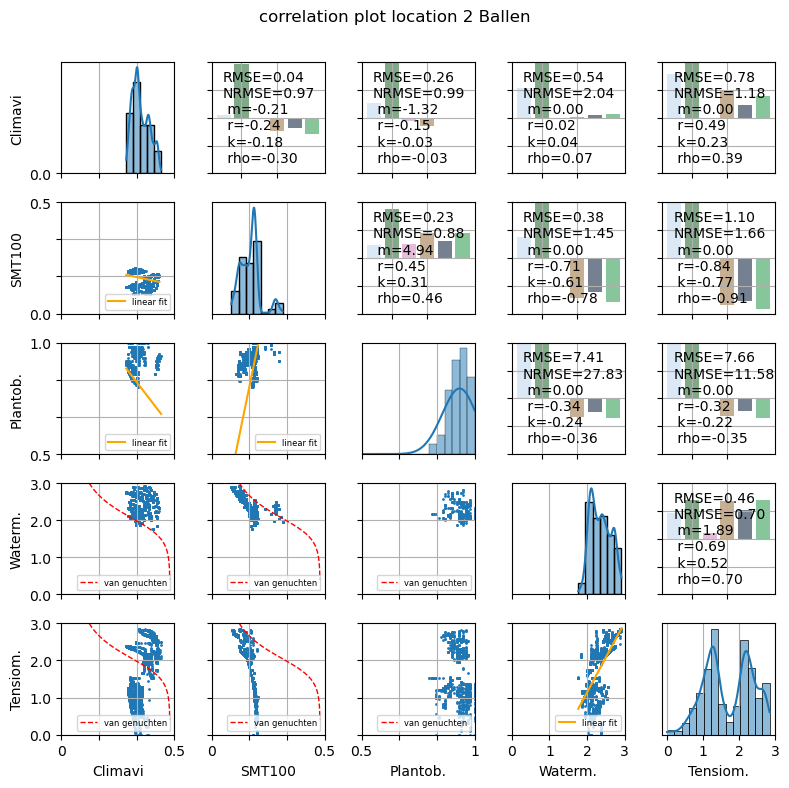

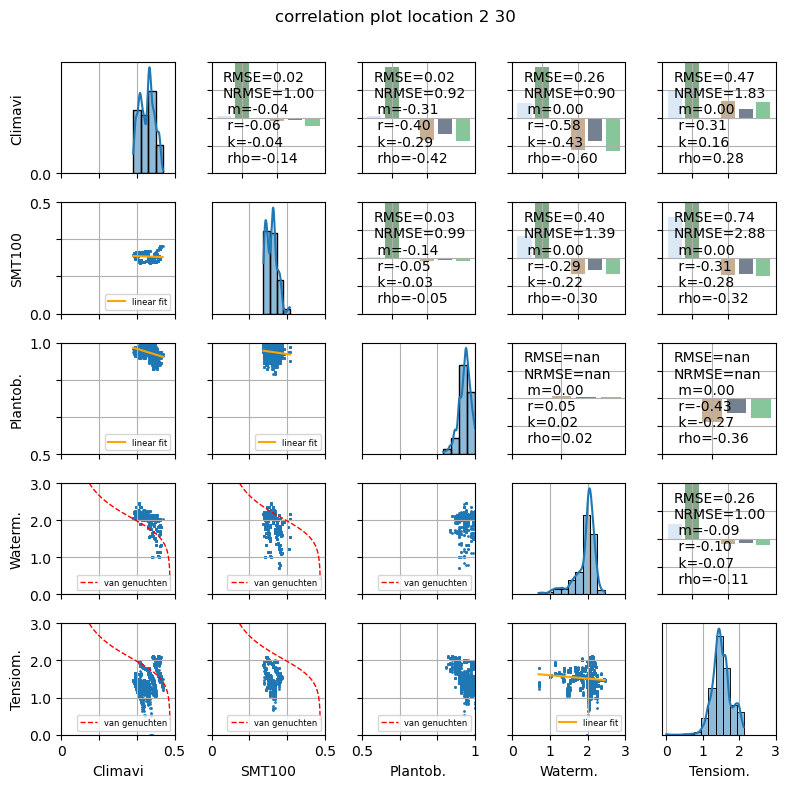

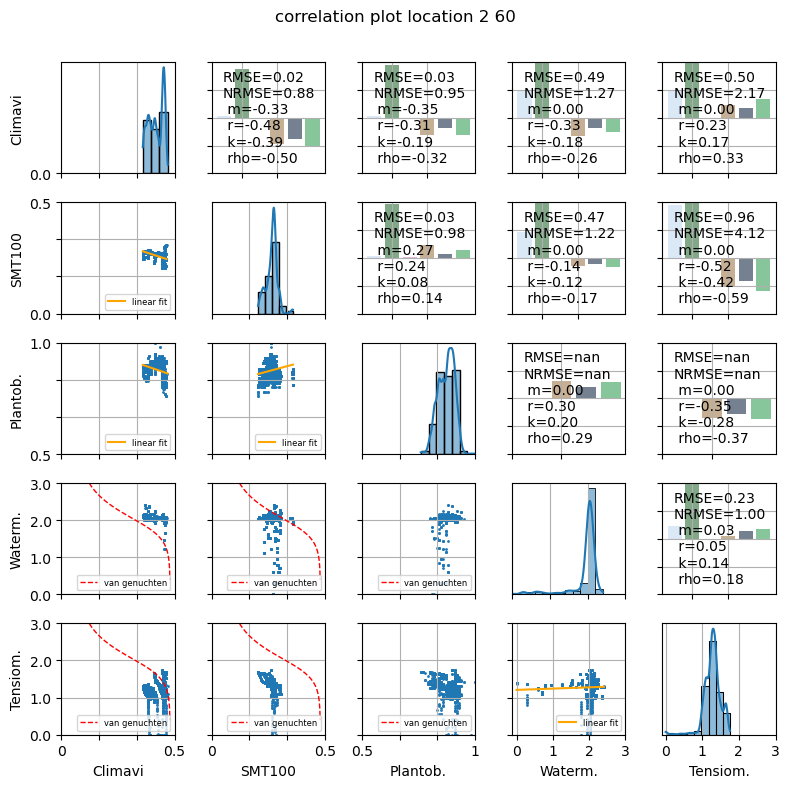

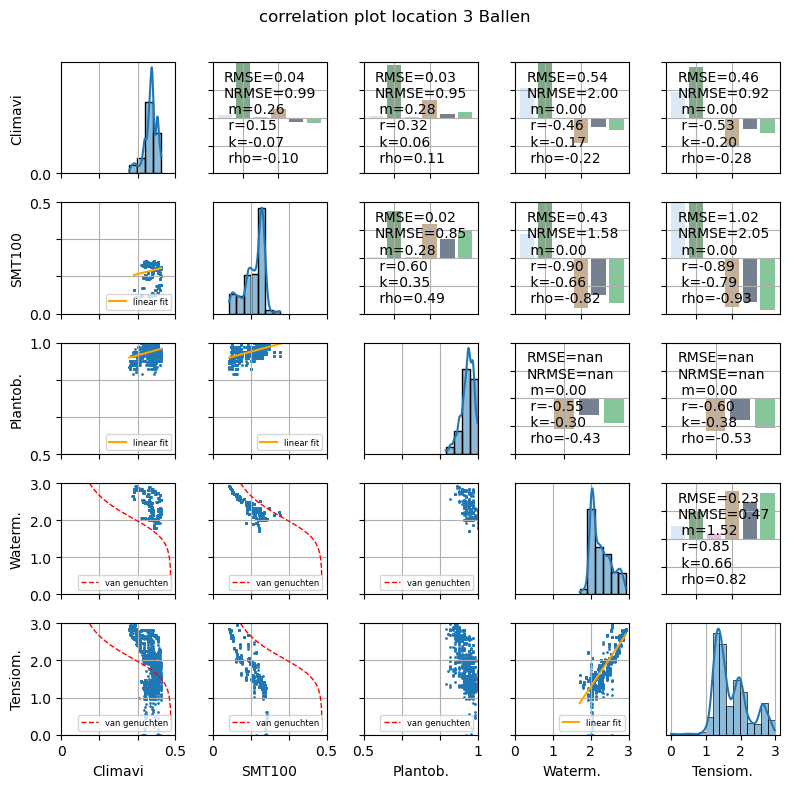

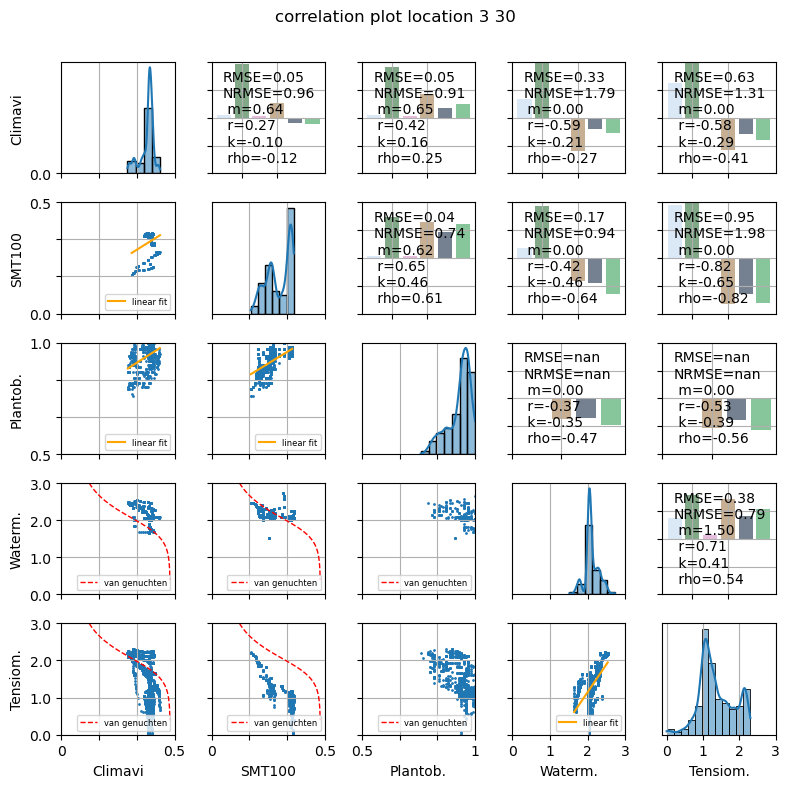

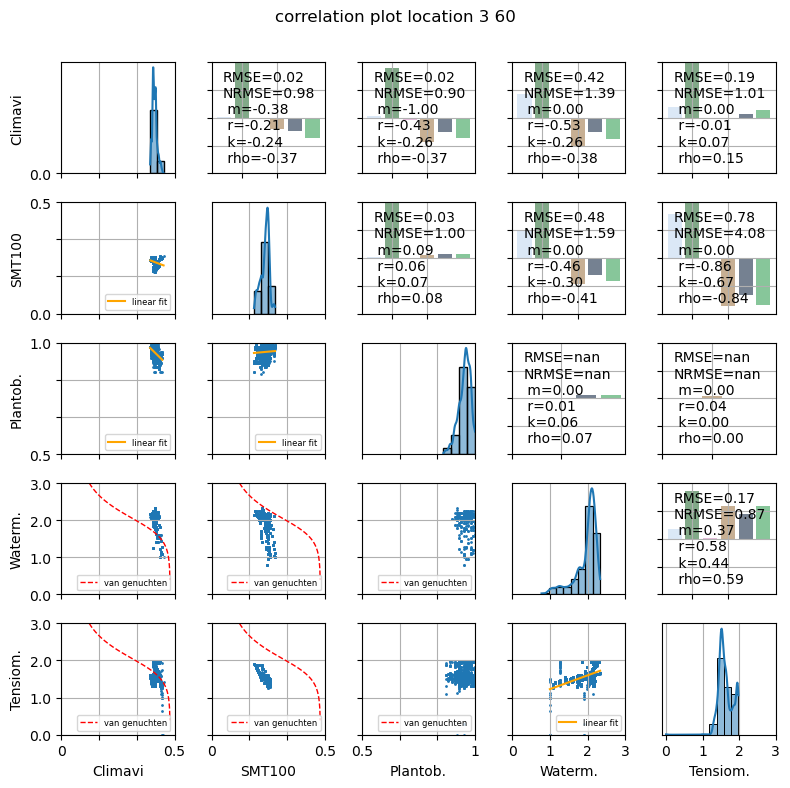

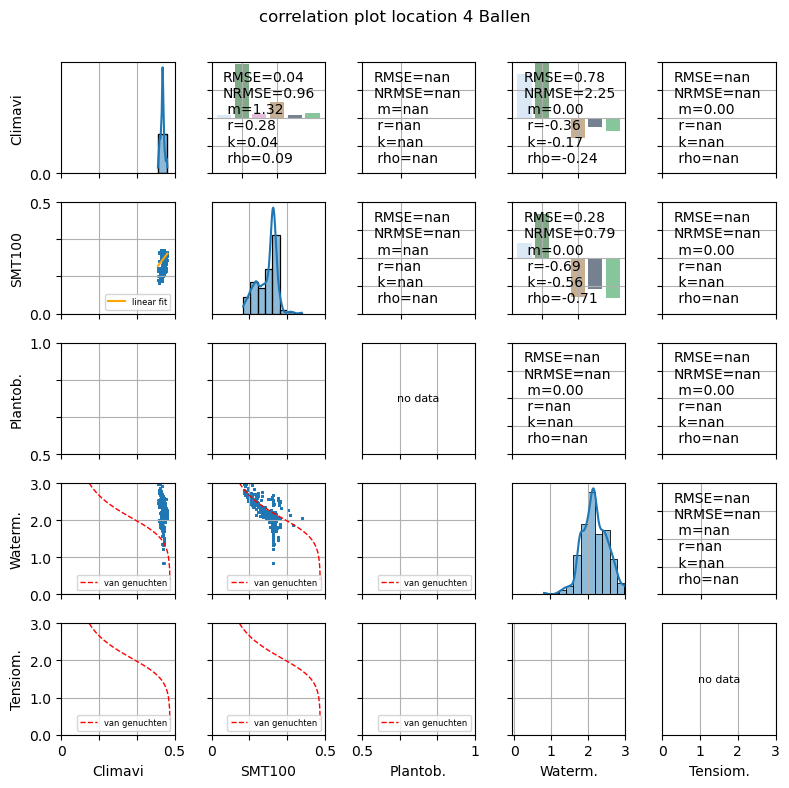

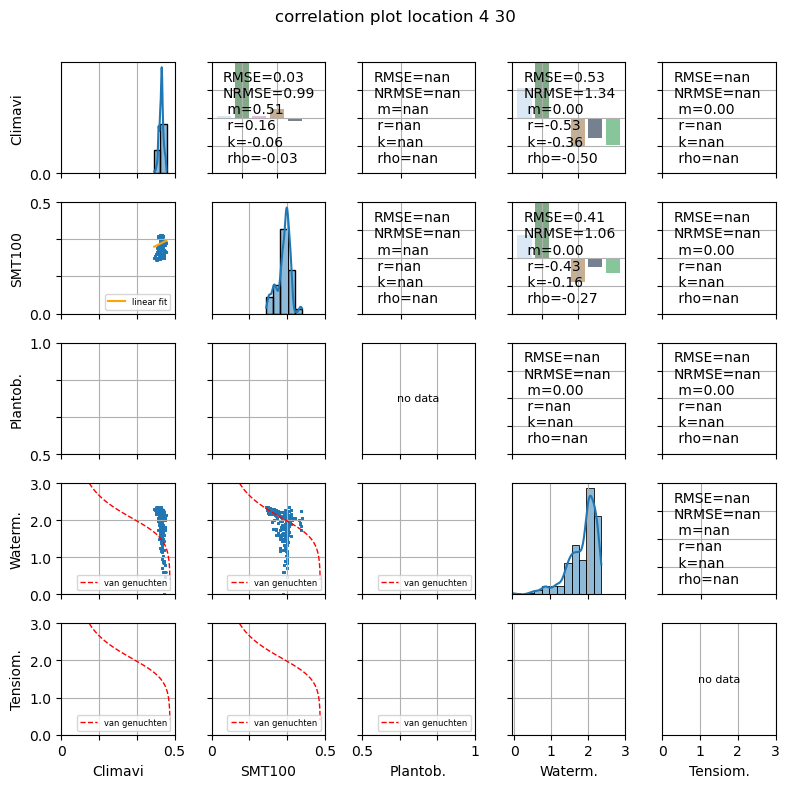

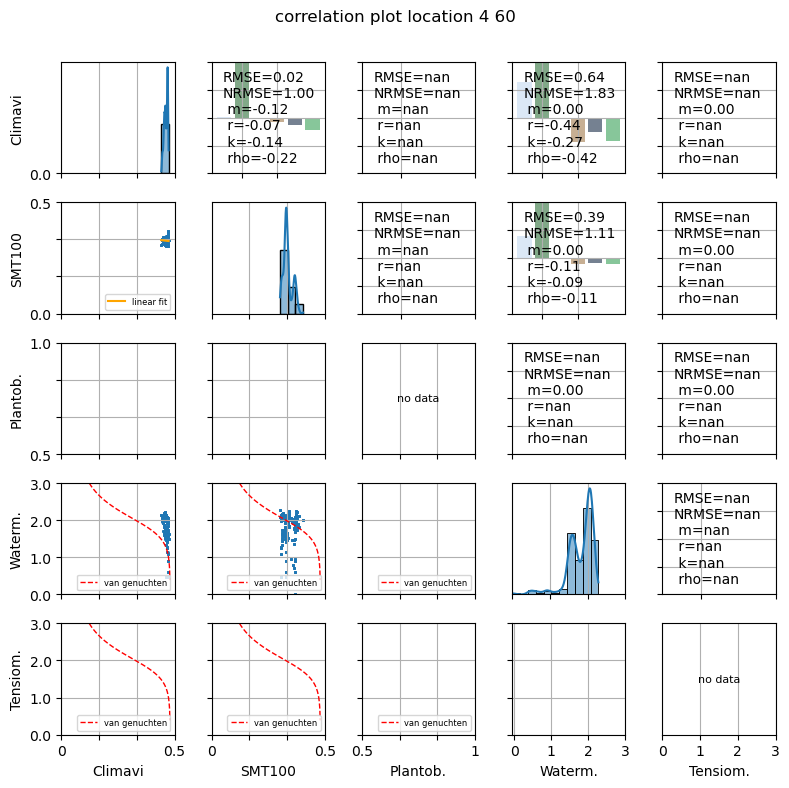

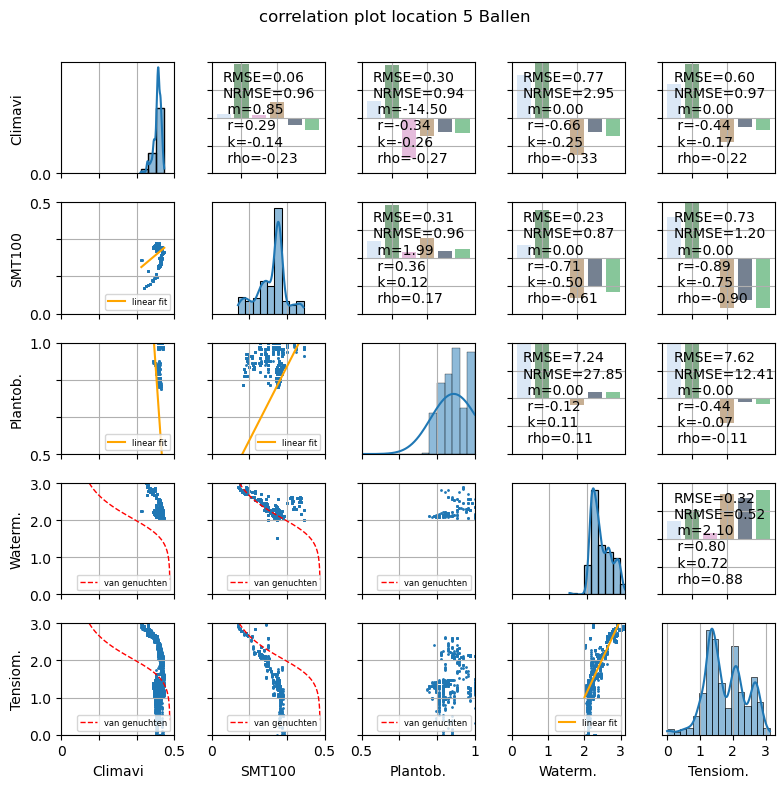

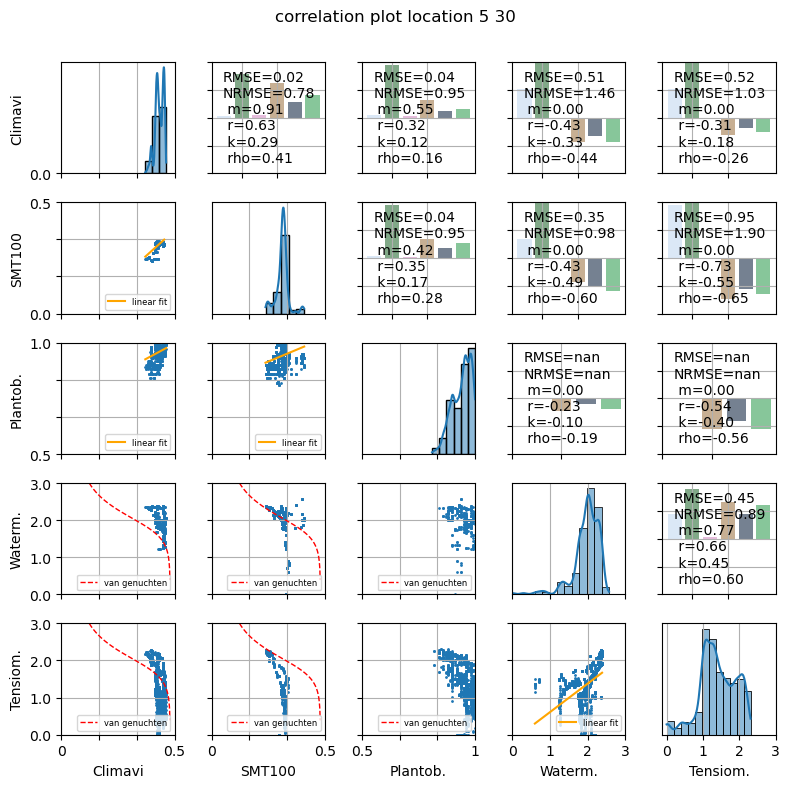

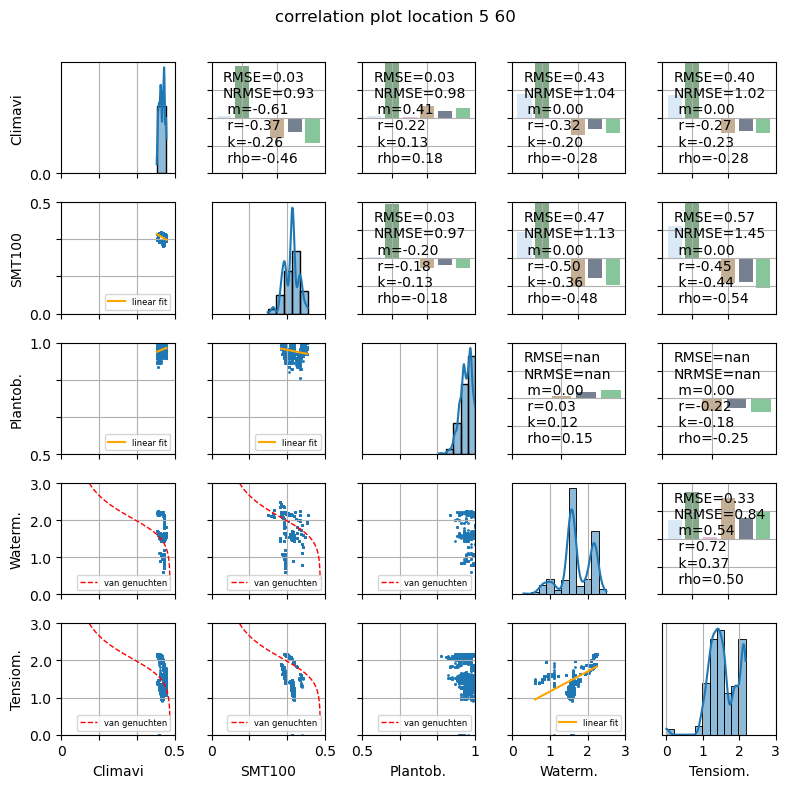

In [64]:
# ========= Loop all locations (1–5) and depths (Ballen, 30, 60) =========
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

collected_metrics = {
    "RMSE": [],
    "NRMSE": [],
    "Pearson": [],
    "Kendall": [],
    "Spearman": []
}


# --- transforms (same math as before) ---
def _tf_div100(s):  return s/100.0
def _tf_log10wm(s): return np.log10(10.0*s)
def _id(s):         return s

def _ffill_limit(s, limit=10):
    return s.fillna(method='ffill', limit=limit)

# --- small helpers to keep visuals stable ---
def _hist_safe(ax, series, transform, binwidth, kde=True, fallback_xlim=(0,1)):
    """Plot hist like before; if data empty/NaN-only, annotate instead of crashing."""
    vals = transform(series)
    vals = vals[np.isfinite(vals)]
    if vals.size >= 2:
        sns.histplot(ax=ax, x=vals, kde=kde, binwidth=binwidth)
    elif vals.size == 1:
        sns.histplot(ax=ax, x=vals, kde=False, bins=1)
    else:
        ax.text(0.5, 0.5, "no data", ha='center', va='center',
                transform=ax.transAxes, fontsize=8)
        ax.set_xlim(*fallback_xlim)
        ax.set_ylim(0, 1)

def scatter_fit(ax, x, y, color='orange', do_ffill=False, label='linear fit', xc_name=None, yc_name=None):
    xs = x.copy()
    ys = y.copy()
    if do_ffill:
        xs = _ffill_limit(xs)
        ys = _ffill_limit(ys)

    xv = xs.values
    yv = ys.values
    idx = np.isfinite(xv) & np.isfinite(yv)

    ax.scatter(xs, ys, 1)
    if idx.sum() < 2:
        return np.nan, np.nan, np.nan

    xv = xv[idx]
    yv = yv[idx]

    coeff = np.polyfit(xv, yv, 1)
    m, b = coeff[0], coeff[1]
    y_pred = m * xv + b
    xHelp = np.linspace(min(xv), max(xv), 100)
    ax.plot(xHelp, m * xHelp + b, color=color, label=label)
    ax.legend(loc='lower right', fontsize=6)

    rmse = calc_rmse(yv, y_pred)
    std_y = np.std(yv)
    nrmse_std = rmse / std_y if std_y else np.nan

    if xc_name and yc_name:
        print(f"[{xc_name} vs {yc_name}] RMSE: {rmse:.3f}, std(y): {std_y:.3f}, NRMSE: {nrmse_std:.3f}")
    return m, rmse, nrmse_std

def calc_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def _fmt_bar_text(rmse, nrmse_std, m_orig, rP, rK, rS, scale=20):
    return (
        'RMSE='  + "{:.2f}".format(rmse) +
        '\nNRMSE='  + "{:.2f}".format(nrmse_std) +
        '\n m='+ "{:.2f}".format(m_orig) +
        '\n r='+ "{:.2f}".format(rP) +
        '\n k='+ "{:.2f}".format(rK) +
        '\n rho='+ "{:.2f}".format(rS)
    )
       

def corr_bar(ax, vals, txt, colors):
    ax.bar(np.arange(len(vals)), vals, color=colors[:len(vals)])
    ax.text(0.1, 0.93, txt, ha='left', va='top', multialignment='left', transform=ax.transAxes)


def _apply_axis_styles(axs):
    # === Your original axis labels & limits (unchanged) ===
    axs[0,0].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], yticks=[-0.5, 0], xlim=[0,0.5], ylabel="Climavi")
    axs[0,0].set_ylim(bottom=0)
    for j in [1,2,3,4]:
        axs[0,j].set(ylim=[-1,1], yticks=[-1, -0.5, 0, 0.5, 1], yticklabels=['', '', '', '', ''], xticks=[1,3], xticklabels=['', ''])

    axs[1,0].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], xlim=[0,0.5], yticks=[0,0.167,0.334,0.5], yticklabels=['0.0', '', '', '0.5'], ylim=[0,0.5], ylabel="SMT100")
    axs[1,1].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], xlim=[0,0.5])
    for j in [2,3,4]:
        axs[1,j].set(ylim=[-1,1], yticks=[-1, -0.5, 0, 0.5, 1], yticklabels=['', '', '', '', ''], xticks=[1,3], xticklabels=['', ''])

    axs[2,0].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], xlim=[0,0.5], yticks=[0.5,0.667,0.834,1], yticklabels=['0.5', '', '', '1.0'], ylim=[0.5,1], ylabel="Plantob.")
    axs[2,1].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], xlim=[0,0.5], yticks=[0.5,0.667,0.834,1], yticklabels=['', '', '', ''], ylim=[0.5,1])
    axs[2,2].set(xticks=[0.5,0.667,0.834,1], xticklabels=['', '', '', ''], xlim=[0.5,1])
    for j in [3,4]:
        axs[2,j].set(ylim=[-1,1], yticks=[-1, -0.5, 0, 0.5, 1], yticklabels=['', '', '', '', ''], xticks=[1,3], xticklabels=['', ''])

    axs[3,0].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], xlim=[0,0.5], yticks=[-0.5,0,1,2,3], ylim=[0,3], ylabel="Waterm.")
    axs[3,1].set(xticks=[0,0.167,0.334,0.5], xticklabels=['', '', '', ''], xlim=[0,0.5], yticks=[0,1,2,3], yticklabels=['', '', '', ''], ylim=[0,3])
    axs[3,2].set(xticks=[0.5,0.667,0.834,1], xticklabels=['', '', '', ''], xlim=[0.5,1], yticks=[0,1,2,3], yticklabels=['', '', '', ''], ylim=[0,3])
    axs[3,3].set(xticks=[0,1,2,3], xticklabels=['', '', '', ''], xlim=[0,3])
    axs[3,4].set(ylim=[-1,1], yticks=[-1, -0.5, 0, 0.5, 1], yticklabels=['', '', '', '', ''], xticks=[1,3], xticklabels=['', ''])

    axs[4,0].set(xticks=[0,0.167,0.334,0.5], xticklabels=['0', '', '', '0.5'], yticks=[-0.5,0,1,2,3], xlim=[0,0.5], ylim=[0,3], xlabel="Climavi", ylabel="Tensiom.")
    axs[4,1].set(xticks=[0,0.167,0.334,0.5], xticklabels=['0', '', '', '0.5'], yticks=[0,1,2,3], yticklabels=['', '', '', ''], xlim=[0,0.5], ylim=[0,3], xlabel="SMT100")
    axs[4,2].set(xticks=[0.5,0.667,0.834,1], xticklabels=['0.5', '', '', '1'], yticks=[0,1,2,3], yticklabels=['', '', '', ''], ylim=[0,3], xlim=[0.5,1], xlabel="Plantob.")
    axs[4,3].set(xticks=[0,1,2,3], yticks=[0,1,2,3], ylim=[0,3], yticklabels='', xlabel="Waterm.")
    axs[4,4].set(xticks=[0,1,2,3], xlabel="Tensiom.")

from sklearn.metrics import r2_score, root_mean_squared_error

def plot_van_genuchten(ax, x_data, y_data, color='red', label='van genuchten'):
    """
    Draws van Genuchten curve and returns R² and RMSE between curve and measured data.
    """
    # Van Genuchten parameters (example values; adjust if needed)
    theta_r = 0.06
    theta_s = 0.48
    alpha = 0.015  # cm⁻¹
    n = 1.7
    m = 1 - 1/n

    # Generate theta values from 0.01 to 0.5
    theta = np.linspace(0.01, 0.5, 500)

    # Compute pF = log10(h(θ))
    with np.errstate(divide='ignore', invalid='ignore'):
        Se = (theta - theta_r) / (theta_s - theta_r)
        Se = np.clip(Se, 1e-6, 1)
        h_cm = ((Se ** (-1/m) - 1) ** (1/n)) / alpha
        pF = np.log10(h_cm)
    
    # Filter valid plotting range
    mask = (pF >= 0) & (pF <= 3)
    ax.plot(theta[mask], pF[mask], color=color, linestyle='--', linewidth=1, label=label)
    ax.legend(loc='lower right', fontsize=6)

    # Compute predictions for input x_data
    x_data_clipped = np.clip(x_data, 0.01, 0.5)
    Se_data = (x_data_clipped - theta_r) / (theta_s - theta_r)
    Se_data = np.clip(Se_data, 1e-6, 1)
    h_data = ((Se_data ** (-1/m) - 1) ** (1/n)) / alpha
    pF_pred = np.log10(h_data)

    # Only use pairs where both x and y are finite
    valid = np.isfinite(pF_pred) & np.isfinite(y_data)
    if valid.sum() < 2:
        return np.nan, np.nan

    # R² and RMSE between predicted (van Genuchten) and measured
    r2 = r2_score(y_data[valid], pF_pred[valid])
    rmse = root_mean_squared_error(y_data[valid], pF_pred[valid])

    return r2, rmse




def _plot_one(tree:int, depth:str, D):
    """
    Reproduziert exakt dein 5×5 Layout für Baum <tree> und Tiefe <depth>.
    D ist Data_Baum_{tree}_{depth}.
    """
    # column names
    cC = f"Data_Climavi_{tree}_{depth}"
    cS = f"Data_SMT100_{tree}_{depth}"
    cP = f"Data_Plantobelly_{tree}_{depth}"
    cW = f"Data_Watermark_{tree}_{depth}"
    cT = f"Data_Tensiomark_{tree}_{depth}"

    # correlations
    corrP  = D.drop(columns=['timestamp']).corr(method='pearson')
    corrK  = D.drop(columns=['timestamp']).corr(method='kendall')
    corrS  = D.drop(columns=['timestamp']).corr(method='spearman')

    # figure & histograms
    f, axs = plt.subplots(5, 5, figsize=(8,8))
    f.suptitle(f'correlation plot location {tree} {depth}')

    _hist_safe(axs[0,0], D[cC], _tf_div100, 1/30, kde=True,  fallback_xlim=(0,0.5))
    _hist_safe(axs[1,1], D[cS], _tf_div100, 1/30, kde=True,  fallback_xlim=(0,0.5))
    _hist_safe(axs[2,2], D[cP], _tf_div100, 1/30, kde=True,  fallback_xlim=(0.5,1.0))
    _hist_safe(axs[3,3], D[cW], _tf_log10wm, 1/5, kde=True,  fallback_xlim=(0,3))
    _hist_safe(axs[4,4], D[cT], _id,        1/5, kde=True,  fallback_xlim=(0,3))

    # clear labels
    for i in range(5):
        for j in range(5):
            if i<4 and j>0:
                axs[i,j].set(xticks=[], xlabel="")
                axs[i,j].set(yticks=[], ylabel="")
            if i<4 and j==0:
                axs[i,j].set(xticks=[], xlabel="")
            if i==4 and j>0:
                axs[i,j].set(yticks=[], ylabel="")

    # grid
    for x in range(5):
        for y in range(5):
            axs[x,y].grid(visible=True, which='major', axis='both')

    # scatter + fits
    NRMSE_STD = np.full((5,5), np.nan)
    M  = np.zeros((5,5))
    pairs = [
        (1,0, cC, cS, _tf_div100, _tf_div100, False),
        (2,0, cC, cP, _tf_div100, _tf_div100, False),
        (3,0, cC, cW, _tf_div100, _tf_log10wm, False),
        (4,0, cC, cT, _tf_div100, _id,        False),

        (2,1, cS, cP, _tf_div100, _tf_div100, True),
        (3,1, cS, cW, _tf_div100, _tf_log10wm, True),
        (4,1, cS, cT, _tf_div100, _id,         True),

        (3,2, cP, cW, _tf_div100, _tf_log10wm, True),
        (4,2, cP, cT, _tf_div100, _id,         True),

        (4,3, cW, cT, _tf_log10wm, _id,        True),
    ]

    for (i, j, xc, yc, fx, fy, do_ffill) in pairs:
        xvals = fx(D[xc])
        yvals = fy(D[yc])


        if (i, j) in [(1,0), (2,0), (2,1), (4,3)]:
            m, rmse, nrmse_std = scatter_fit(axs[i, j], xvals, yvals, color='orange', do_ffill=do_ffill, xc_name=xc, yc_name=yc)
            std = np.std(yvals[np.isfinite(yvals)])
            print(f"[bar input] RMSE: {rmse:.3f}, std: {std:.3f}, NRMSE: {nrmse_std:.3f} for {xc} vs {yc}")
            M[i, j] = m
            NRMSE_STD[i, j] = nrmse_std

        elif (i, j) in [(3,0), (3,1), (3,2), (4,0), (4,1), (4,2)]:
            axs[i, j].scatter(xvals, yvals, s=1)
            _, rmse_vg = plot_van_genuchten(axs[i, j], xvals, yvals)
            std = np.std(yvals[np.isfinite(yvals)])
            nrmse_std = rmse_vg / std if std else np.nan

            NRMSE_STD[i, j] = nrmse_std

        else:
            M[i, j] = np.nan

        


    # bars
    colors = ['#dbe8f6', '#81a988', '#e5bcdc', '#c7af93', '#758191', "#87C69A"]
    scale  = 20
    bar_specs = [
        ((0,1), (1,0), cS, cC),
        ((0,2), (2,0), cP, cC),
        ((0,3), (3,0), cW, cC),
        ((0,4), (4,0), cT, cC),
        ((1,2), (2,1), cP, cS),
        ((1,3), (3,1), cW, cS),
        ((1,4), (4,1), cT, cS),
        ((2,3), (3,2), cW, cP),
        ((2,4), (4,2), cT, cP),
        ((3,4), (4,3), cT, cW),
    ]
    for (ax_ij, mat_ij, num, den) in bar_specs:
        ai, aj = ax_ij
        mi, mj = mat_ij

        # Get original y-values again to compute std
        xc, yc = den, num
        if xc not in D.columns or yc not in D.columns:
            continue

        fx = _tf_log10wm if "Watermark" in xc else (_id if "Tensio" in xc else _tf_div100)
        fy = _tf_log10wm if "Watermark" in yc else (_id if "Tensio" in yc else _tf_div100)

        yvals = fy(D[yc])
        yvals = yvals[np.isfinite(yvals)]

        std = np.std(yvals)
        nrmse_std = NRMSE_STD[mi, mj]
        mv  = M[mi, mj] / scale
        rP  = corrP.loc[num][den]
        rK  = corrK.loc[num][den]
        rS  = corrS.loc[num][den]

        rmse = nrmse_std * std if np.isfinite(nrmse_std) and np.isfinite(std) else np.nan
        print(f"[bar plot] RMSE: {rmse:.3f}, std: {std:.3f}, NRMSE: {nrmse_std:.3f}, m: {mv * scale:.3f}, r: {rP:.3f}, k: {rK:.3f}, rho: {rS:.3f} ({num} vs {den})")
        vals = [rmse, nrmse_std, mv, rP, rK, rS]
        txt  = _fmt_bar_text(rmse, nrmse_std, M[mi, mj], rP, rK, rS, scale=scale)

        corr_bar(axs[ai, aj], vals, txt, colors)

        # Store metrics for boxplot generation
        pair_label = f"{num.split('_')[1]}-{den.split('_')[1]}"
        collected_metrics["RMSE"].append({"Tree": tree, "Depth": depth, "Pair": pair_label, "Value": rmse})
        collected_metrics["NRMSE"].append({"Tree": tree, "Depth": depth, "Pair": pair_label, "Value": nrmse_std})
        collected_metrics["Pearson"].append({"Tree": tree, "Depth": depth, "Pair": pair_label, "Value": rP})
        collected_metrics["Kendall"].append({"Tree": tree, "Depth": depth, "Pair": pair_label, "Value": rK})
        collected_metrics["Spearman"].append({"Tree": tree, "Depth": depth, "Pair": pair_label, "Value": rS})





    # axes styling (exactly like your originals)
    _apply_axis_styles(axs)
    plt.tight_layout(rect=[0, 0, 1, 0.97])

# ---------- Loop all sites & depths, pull DataFrames by name, plot ----------
trees  = [1, 2, 3, 4, 5]
depths = ['Ballen', '30', '60']

for tree in trees:
    for depth in depths:
        varname = f"Data_Baum_{tree}_{depth}"
        if varname in globals():
            D = globals()[varname]
            needed = {
                f"Data_Climavi_{tree}_{depth}",
                f"Data_SMT100_{tree}_{depth}",
                f"Data_Plantobelly_{tree}_{depth}",
                f"Data_Watermark_{tree}_{depth}",
                f"Data_Tensiomark_{tree}_{depth}",
                "timestamp",
            }
            # Skip quietly if columns missing
            if needed.issubset(set(D.columns)):
                _plot_one(tree, depth, D)
            # else: silently skip (or print a note if you want)
        # else: dataframe not defined -> skip
# ============================================================================

# ==== Save all open figures as PDFs into ./plots ====
import re
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt

outdir = Path("plots")
outdir.mkdir(parents=True, exist_ok=True)

def _safe_name(text: str) -> str:
    # lower, replace non-word chars by underscores, collapse repeats
    text = (text or "").strip().lower()
    text = re.sub(r"[^\w\-]+", "_", text)
    text = re.sub(r"_+", "_", text).strip("_")
    return text or "figure"

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

saved = []
for num in plt.get_fignums():
    fig = plt.figure(num)
    # Prefer the figure suptitle (matches your "Datenanalyse Data_Baum_X_Y" titles)
    title = None
    if getattr(fig, "_suptitle", None) is not None:
        try:
            title = fig._suptitle.get_text()
        except Exception:
            title = None

    base = _safe_name(title) if title else f"figure_{num}"
    # If you want a timestamp in filenames, uncomment the next line:
    # base = f"{base}_{timestamp}"

    pdf_path = outdir / f"{base}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight")
    saved.append(str(pdf_path))

print("Saved PDFs:")
for p in saved:
    print("  -", p)
# ================================================


C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Value"] = df_subset["Value"].abs()
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["MetricDisplay"] = df_subset["Metric"].map(metric_display_names)


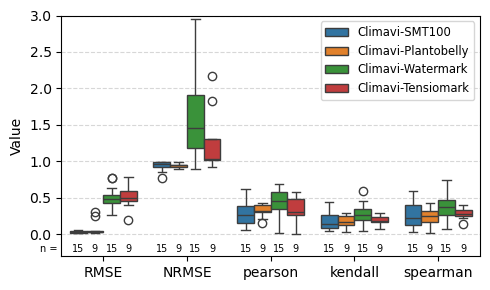

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Value"] = df_subset["Value"].abs()
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["MetricDisplay"] = df_subset["Metric"].map(metric_display_names)


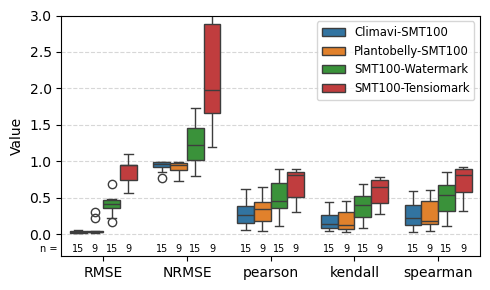

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Value"] = df_subset["Value"].abs()
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["MetricDisplay"] = df_subset["Metric"].map(metric_display_names)


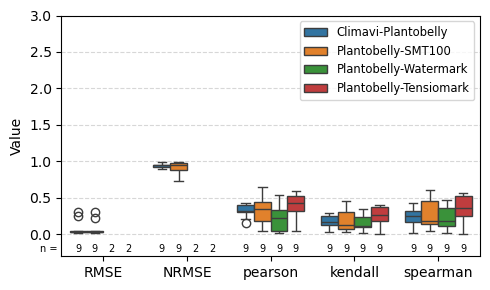

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Value"] = df_subset["Value"].abs()
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["MetricDisplay"] = df_subset["Metric"].map(metric_display_names)


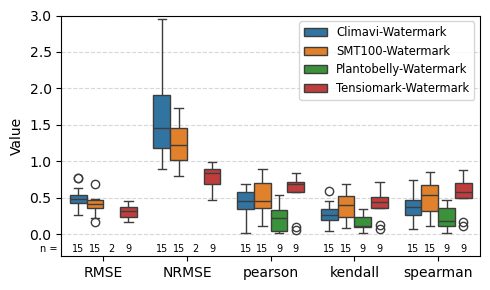

C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["Value"] = df_subset["Value"].abs()
C:\Users\tmaie\AppData\Local\Temp\ipykernel_32256\1362850541.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset["MetricDisplay"] = df_subset["Metric"].map(metric_display_names)


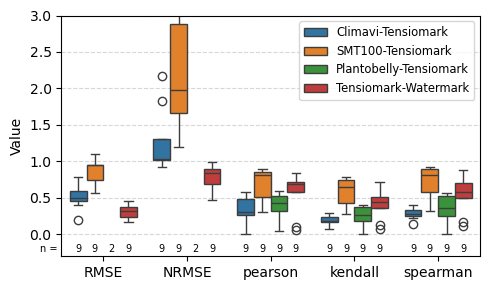

In [67]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Flatten collected_metrics into one DataFrame
rows = []
for metric_name, entries in collected_metrics.items():
    for entry in entries:
        row = entry.copy()
        row["Metric"] = metric_name
        s1, s2 = row["Pair"].split("-")
        row["Pair"] = "-".join(sorted([s1, s2]))
        rows.append(row)

df_metrics = pd.DataFrame(rows)


# Rename metrics only for plotting (not in the original data)
df_metrics["Metric"] = df_metrics["Metric"].replace({"NRMSE": "NRMSE_std"})

# Define desired plot order and display name mapping
metric_display_names = {
    "RMSE": "RMSE",
    "NRMSE_std": "NRMSE",
    "Pearson": "pearson",
    "Kendall": "kendall",
    "Spearman": "spearman"
}
metrics_to_plot = list(metric_display_names.keys())
df_metrics = df_metrics[df_metrics["Metric"].isin(metrics_to_plot)]

# Normalize group pairs
def normalize(pair_list):
    return ["-".join(sorted(pair)) for pair in pair_list]

comparison_groups = [
    normalize([("Climavi", "SMT100"), ("Climavi", "Plantobelly"), ("Climavi", "Watermark"), ("Climavi", "Tensiomark")]),
    normalize([("SMT100", "Plantobelly"), ("SMT100", "Watermark"), ("SMT100", "Tensiomark"), ("Climavi", "SMT100")]),
    normalize([("Climavi", "Plantobelly"), ("SMT100", "Plantobelly"), ("Plantobelly", "Watermark"), ("Plantobelly", "Tensiomark")]),
    normalize([("Climavi", "Watermark"), ("SMT100", "Watermark"), ("Plantobelly", "Watermark"), ("Watermark", "Tensiomark")]),
    normalize([("Climavi", "Tensiomark"), ("SMT100", "Tensiomark"), ("Plantobelly", "Tensiomark"), ("Watermark", "Tensiomark")]),
]

for group_idx, group_pairs in enumerate(comparison_groups, start=1):
    df_subset = df_metrics[df_metrics["Pair"].isin(group_pairs)]

    if df_subset.empty:
        print(f"No available data for group {group_idx}")
        continue

    df_subset["Value"] = df_subset["Value"].abs()
    df_subset["MetricDisplay"] = df_subset["Metric"].map(metric_display_names)

    stats = df_subset.groupby(["MetricDisplay", "Pair"]).agg(
        n=("Value", "count"),
        med=("Value", "median")
    ).reset_index()

    fig = plt.figure(figsize=(5, 3))
    ax = sns.boxplot(data=df_subset, x="MetricDisplay", y="Value", hue="Pair",
                     order=[metric_display_names[m] for m in metrics_to_plot])

    ax.set_ylim(bottom=-0.3, top=3)
    ax.grid(True, which='major', axis='y', linestyle='--', alpha=0.5)

    hue_order = ax.get_legend_handles_labels()[1]
    n_hue = len(hue_order)
    width = 0.8

    for x_idx, metric in enumerate([metric_display_names[m] for m in metrics_to_plot]):
        for h_idx, pair in enumerate(hue_order):
            entry = stats[(stats["MetricDisplay"] == metric) & (stats["Pair"] == pair)]
            if not entry.empty:
                n_val = int(entry["n"].values[0])
                x = x_idx - width / 2 + h_idx * (width / n_hue) + (width / n_hue) / 2
                ax.text(x, -0.2, f"{n_val}", ha="center", va="center", fontsize=7, color='black')

    #plt.title(f"Group {group_idx}: RMSE, NRMSE & Korrelationen für spezifizierte Sensorpaare")
    ax.text(-0.65, -0.2, 'n =', ha="center", va="center", fontsize=7, color='black')
    plt.xticks(rotation=0)
    plt.xlabel('')
    plt.legend(loc='upper right', fontsize='small', frameon=True)  # Legend inside the plot
    plt.tight_layout()

    outdir = Path("plots")
    base = f"group_{group_idx}_metrics_boxplot"
    pdf_path = outdir / f"{base}.pdf"
    fig.savefig(pdf_path, bbox_inches="tight")
    plt.show()
